# Detección de anomalías en un marco de auditoría continua

## 11. Datos desbalanceados - Modelos no supervisados

### 11.1. Split del dataset

Split del dataset para reservar un conjunto de datos para validación posterior al entrenamiento y desarrollo de los modelos.

In [2]:
# Importación de librerías
import pandas as pd
import numpy as np
import os
import time
import joblib
import matplotlib.pyplot as plt

In [3]:
# Filtro de warnings.
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Carga del dataset.
os.chdir('..')
df = pd.read_csv('df_preprocessed.csv')
df.head()

,day,hour,amount,idOrig,oldbalanceOrig,newbalanceOrig,idDest,oldbalanceDest,newbalanceDest,Cash_in,Cash_out,Debit,Payment,Transfer,isFraud,isFlaggedFraud
0,1,1,9839.64,0,170136.0,160296.36,6353307,0.0,0.0,0,0,0,1,0,0,0
1,1,1,1864.28,1,21249.0,19384.72,6353308,0.0,0.0,0,0,0,1,0,0,0
2,1,1,181.00,2,181.0,0.00,6353309,0.0,0.0,0,0,0,0,1,1,0
3,1,1,181.00,3,181.0,0.00,6353310,21182.0,0.0,0,1,0,0,0,1,0
4,1,1,11668.14,4,41554.0,29885.86,6353311,0.0,0.0,0,0,0,1,0,0,0


In [5]:
# Split del dataset para reservar un conjunto de validación.
from sklearn.model_selection import train_test_split
df_training, df_validation = train_test_split(df, test_size = 0.2, random_state = 42, shuffle = True, stratify = np.array(df['isFraud']))

In [6]:
# Control de frecuencias de clases.
print('Proporcion de clases para dataset de training: %.4f' % (df_training['isFraud'].value_counts()[1] / df_training['isFraud'].value_counts()[0]))
print('Proporcion de clases para dataset de validación: %.4f' % (df_validation['isFraud'].value_counts()[1] / df_validation['isFraud'].value_counts()[0]))

Proporcion de clases para dataset de training: 0.0013
Proporcion de clases para dataset de validación: 0.0013


### 11.2. Balanceo de datos

Para el balanceo de datos, se recurre a una técnica híbrida:
- Por un lado, se submuestrean los registros de la clase mayoritaria, utilizando muestreo sin reposición.
- Por otro lado, se sobremuestrean los registros de la clase minoritaria, utilizando muestreo con reposición.
- Se recurre a un valor de k, que representa el factor de muestreo. A mayor k, mayor es la participación de casos de fraude dentro del nuevo dataset.

In [7]:
# Función para el balanceo de datos.
from sklearn.utils import resample

def balancing(X, y, k):
    # X = dataframe; y = series; k = float
    
    # Submuestreo de la clase mayoritaria.
    index_majority_downsampled = resample(X[y == 0], 
                                       replace = False,
                                       n_samples = int(len(X[y == 0]) * (1 - k)),
                                       random_state = 42).index
    
    # Sobremuestreo de la clase minoritaria.
    index_minority_oversampled = resample(X[y == 1], 
                                       replace = True,
                                       n_samples = int(len(X[y == 1]) * (1 + k)),
                                       random_state = 42).index
    
    indexes = list(index_majority_downsampled) + list(index_minority_oversampled)
    
    return indexes

### 11.3. Clustering - K-Means

https://scikit-learn.org/stable/modules/clustering.html#clustering

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans

#### 11.3.1. Ingeniería de predictores

Se evaluan los métodos de estandarización y normalización de atributos.

Se evalua la eliminación de algunos atributos (día y hora de la operación y códigos de identificación de originante y destinatario, en estos dos últimos casos considerando la naturaleza del modelo).

In [7]:
# Importación de librerías.
import json
from datetime import datetime
from sklearn.model_selection import StratifiedKFold, cross_validate, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, Normalizer, StandardScaler, RobustScaler
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, accuracy_score
from sklearn.cluster import KMeans
from hyperopt import fmin, hp, tpe, space_eval, Trials
from hyperopt.early_stop import no_progress_loss
  
# Definción de la función objetivo.
def objective_func(search_space):
    
    global counter, scorings, estimator
    start_time = time.time()
    counter += 1

    scaler = search_space['scaler']
    selected_columns = search_space['selected_columns']
    skf = StratifiedKFold(random_state = 42, n_splits = 4, shuffle = True)    
    scores = {'Recall': [], 'Precision': [], 'AUC': [], 'Accuracy': [], 'F1-Score': []}
    
    Z = X.drop(list(selected_columns), axis = 1)
    
    if scaler is None:
        None
    else:
        Z_index = Z.index
        Z = scaler.fit_transform(Z)
        Z = pd.DataFrame(Z)
        Z.index = Z_index
    
    for train, test in skf.split(X, y):
        
        X_train = Z.iloc[train, :]
        X_test = Z.iloc[test, :]
        y_train = y.iloc[train]
        y_test = y.iloc[test]

        indexes_train = balancing(X_train, y_train, 0.8)
        indexes_test = balancing(X_test, y_test, 0.8)

        X_train = X_train.loc[indexes_train, :]
        X_test = X_test.loc[indexes_test, :]
        y_train = y_train.loc[indexes_train]
        y_test = y_test.loc[indexes_test]
        
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)

        if sum(y_pred) <= (len(y_pred) - sum(y_pred)):
            None
        else:
            for i, j in enumerate(y_pred):
                if j == 0:
                    y_pred[i] = 1
                else:
                    y_pred[i] = 0
        
        scores['Recall'].append(recall_score(y_test, y_pred))
        scores['Precision'].append(precision_score(y_test, y_pred))
        scores['AUC'].append(roc_auc_score(y_test, y_pred))
        scores['Accuracy'].append(accuracy_score(y_test, y_pred))
        scores['F1-Score'].append(f1_score(y_test, y_pred))
    
    loss = 1 - np.mean(scores['F1-Score']) + np.std(scores['F1-Score'])

    scorings.append({'trial': counter,
                     'search_space' : str(search_space),
                     'scorings' : {'Recall': np.mean(scores['Recall']),
                                   'Precision': np.mean(scores['Precision']),
                                   'AUC': np.mean(scores['AUC']),
                                   'Accuracy': np.mean(scores['Accuracy']),
                                   'Recall_Std': np.std(scores['Recall']),
                                   'Precision_Std': np.std(scores['Precision']),
                                   'AUC_Std': np.std(scores['AUC']),
                                   'Accuracy_Std': np.std(scores['Accuracy']),
                                   'F1-Score': np.mean(scores['F1-Score'])}
                    }
                   )
    
    elapsed_time = time.time() - start_time
    
    print('Trial: %i | Loss: %.4f | Elapsed_time: %.4f seconds' % (counter, loss, elapsed_time))
    
    return loss    

# Función para la impresión de resultados.
def hyperopt_printer(trials):
    print('\nBest Trial:')
    print('Trial ID :', trials.best_trial['tid'])
    print('Loss :', trials.best_trial['result']['loss'])
    print('Params :', space_eval(search_space, best_params), end = '\n\n')

# Función para exportación de resultados a formato JSON.
def json_export(scorings):
    try:
        os.mkdir('hyperopt_optimizations')
    except:
        None

    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M%S")
    path = os.getcwd() + '\hyperopt_optimizations\\'
    filename = 'Opt_' + dt_string + '.json'

    f = open(path + filename, 'w')
    json.dump(scorings, f)
    f.close()
    print('Json file: ' + dt_string + '.json', end = '\n\n')

# Función para la obtención de resultados en formato tabla para visualizar scorings y desvios estándar.
def scorings_to_df(scorings):
    scorings_df = pd.DataFrame(columns = list(scorings[0]['scorings'].keys()))
    for scoring in scorings:
        scorings_df = scorings_df.append(scoring['scorings'], ignore_index = True)

    print('Scoring details:', end = '\n\n')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):  # more options can be specified also
        print(scorings_df)

    return scorings_df

In [8]:
# Subconjunto de registros.
sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.99, random_state = 42)
splitter = StratifiedShuffleSplit(n_splits = 1, train_size = 0.8, random_state = 42)

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:-2]
    y = df_training.iloc[a,:]['isFraud']

# Definición del espacio / dominio de parámetros.
# Combinaciones de columnas.
import itertools
items =  ['day', 'hour', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest']
combinations = []
for item in range(0, len(items) + 1):
    for subset in itertools.combinations(items, item):
        combinations.append(list(subset))

scalers = [None, MinMaxScaler((0, 1)), MinMaxScaler((-1, 1)), MaxAbsScaler(), Normalizer(), StandardScaler(), RobustScaler()]
search_space = {'selected_columns' : hp.choice('selected_columns', combinations),
                'scaler' : hp.choice('scaler', scalers)
               }
estimator = KMeans(random_state = 42, n_clusters = 2)

# Implementación de Hyperopt
counter = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(100), 
                   rstate = rstate)

Trial: 0 | Loss: 0.9697 | Elapsed_time: 24.5016 seconds
Trial: 1 | Loss: 0.9693 | Elapsed_time: 18.1941 seconds                          
Trial: 2 | Loss: 0.9693 | Elapsed_time: 19.3427 seconds                          
Trial: 3 | Loss: 0.9693 | Elapsed_time: 18.6022 seconds                          
Trial: 4 | Loss: 0.9693 | Elapsed_time: 18.6825 seconds                          
Trial: 5 | Loss: 1.0001 | Elapsed_time: 18.6155 seconds                          
Trial: 6 | Loss: 0.9687 | Elapsed_time: 17.9608 seconds                          
Trial: 7 | Loss: 0.9972 | Elapsed_time: 27.7031 seconds                          
Trial: 8 | Loss: 0.9697 | Elapsed_time: 22.8052 seconds                          
Trial: 9 | Loss: 0.9693 | Elapsed_time: 16.6519 seconds                          
Trial: 10 | Loss: 0.9875 | Elapsed_time: 31.8266 seconds                          
Trial: 11 | Loss: 1.0000 | Elapsed_time: 17.4352 seconds                          
Trial: 12 | Loss: 0.9693 | Elapsed_time:

In [9]:
# Impresión de resultados.
hyperopt_printer(trials)
scorings_df = scorings_to_df(scorings)


Best Trial:
Trial ID : 60
Loss : 0.86353453433305
Params : {'scaler': None, 'selected_columns': ('hour', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest')}

Scoring details:

      Recall  Precision       AUC  Accuracy  Recall_Std  Precision_Std   AUC_Std  Accuracy_Std  F1-Score
0   0.665755   0.015756  0.591076  0.518113    0.009819       0.000256  0.005329      0.001103  0.030783
1   0.499915   0.016281  0.574332  0.647039    0.013158       0.000446  0.006838      0.000984  0.031534
2   0.499915   0.016281  0.574332  0.647039    0.013158       0.000446  0.006838      0.000984  0.031534
3   0.499915   0.016281  0.574332  0.647039    0.013158       0.000446  0.006838      0.000984  0.031534
4   0.499915   0.016281  0.574332  0.647039    0.013158       0.000446  0.006838      0.000984  0.031534
5   0.004785   0.000253  0.362697  0.712381    0.005474       0.000290  0.032128      0.058762  0.000481
6   0.129699   0.018184  0.524134  0.909501    

#### 11.3.2. Optimización de hiperparámetros

Best Trial:
Trial ID : 60
Loss : 0.86353453433305
Params : {'scaler': None, 'selected_columns': ('hour', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest')}

In [27]:
# Importación de librerías.
import json
from datetime import datetime
from sklearn.model_selection import StratifiedKFold, cross_validate, StratifiedShuffleSplit
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, accuracy_score
from sklearn.cluster import KMeans
from hyperopt import fmin, hp, tpe, space_eval, Trials
from hyperopt.early_stop import no_progress_loss
from math import log, ceil, floor
  
# Definción de la función objetivo.
def objective_func(search_space):
    
    global counter, scorings, estimator
    start_time = time.time()
    counter += 1
    
    scaler = search_space['scaler']
    selected_columns = search_space['selected_columns']
    search_space['params']['n_init'] = ceil(search_space['params']['n_init'])
    search_space['params']['max_iter'] = ceil(search_space['params']['max_iter'])
    estimator.set_params(**search_space['params'])
    skf = StratifiedKFold(random_state = 42, n_splits = 4, shuffle = True)    
    scores = {'Recall': [], 'Precision': [], 'AUC': [], 'Accuracy': [], 'F1-Score': []}
    
    Z = X.drop(list(selected_columns), axis = 1)
    
    if scaler is None:
        None
    else:
        Z_index = Z.index
        Z = scaler.fit_transform(Z)
        Z = pd.DataFrame(Z)
        Z.index = Z_index
    
    for train, test in skf.split(X, y):
        
        X_train = Z.iloc[train, :]
        X_test = Z.iloc[test, :]
        y_train = y.iloc[train]
        y_test = y.iloc[test]

        indexes_train = balancing(X_train, y_train, 0.8)
        indexes_test = balancing(X_test, y_test, 0.8)

        X_train = X_train.loc[indexes_train, :]
        X_test = X_test.loc[indexes_test, :]
        y_train = y_train.loc[indexes_train]
        y_test = y_test.loc[indexes_test]
        
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)

        if sum(y_pred) <= (len(y_pred) - sum(y_pred)):
            None
        else:
            for i, j in enumerate(y_pred):
                if j == 0:
                    y_pred[i] = 1
                else:
                    y_pred[i] = 0
        
        scores['Recall'].append(recall_score(y_test, y_pred))
        scores['Precision'].append(precision_score(y_test, y_pred))
        scores['AUC'].append(roc_auc_score(y_test, y_pred))
        scores['Accuracy'].append(accuracy_score(y_test, y_pred))
        scores['F1-Score'].append(f1_score(y_test, y_pred))
    
    loss = 1 - np.mean(scores['F1-Score']) + np.std(scores['F1-Score'])

    scorings.append({'trial': counter,
                     'search_space' : str(search_space),
                     'scorings' : {'Recall': np.mean(scores['Recall']),
                                   'Precision': np.mean(scores['Precision']),
                                   'AUC': np.mean(scores['AUC']),
                                   'Accuracy': np.mean(scores['Accuracy']),
                                   'Recall_Std': np.std(scores['Recall']),
                                   'Precision_Std': np.std(scores['Precision']),
                                   'AUC_Std': np.std(scores['AUC']),
                                   'Accuracy_Std': np.std(scores['Accuracy']),
                                   'F1-Score': np.mean(scores['F1-Score'])}
                    }
                   )
    
    elapsed_time = time.time() - start_time
    
    print('Trial: %i | Loss: %.4f | Elapsed_time: %.4f seconds' % (counter, loss, elapsed_time))
    
    return loss    

# Función para la impresión de resultados.
def hyperopt_printer(trials):
    print('\nBest Trial:')
    print('Trial ID :', trials.best_trial['tid'])
    print('Loss :', trials.best_trial['result']['loss'])
    print('Params :', space_eval(search_space, best_params), end = '\n\n')

# Función para exportación de resultados a formato JSON.
def json_export(scorings):
    try:
        os.mkdir('hyperopt_optimizations')
    except:
        None

    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M%S")
    path = os.getcwd() + '\hyperopt_optimizations\\'
    filename = 'Opt_' + dt_string + '.json'

    f = open(path + filename, 'w')
    json.dump(scorings, f)
    f.close()
    print('Json file: ' + dt_string + '.json', end = '\n\n')

# Función para la obtención de resultados en formato tabla para visualizar scorings y desvios estándar.
def scorings_to_df(scorings):
    scorings_df = pd.DataFrame(columns = list(scorings[0]['scorings'].keys()))
    for scoring in scorings:
        scorings_df = scorings_df.append(scoring['scorings'], ignore_index = True)

    print('Scoring details:', end = '\n\n')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):  # more options can be specified also
        print(scorings_df)

    return scorings_df

In [30]:
# Subconjunto de registros.
sss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.99, random_state = 42)

for a, b in sss.split(df_training, y = df_training['isFraud']):
    X = df_training.iloc[a,:-2]
    y = df_training.iloc[a,-2]
    
# Definición del espacio / dominio de parámetros.
estimator = KMeans(random_state = 42, n_clusters = 2)
search_space = {'selected_columns' : ['hour', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest'],
                'scaler' : None,
                'params' : {'init' : hp.choice('init', ['k-means++', 'random']),
                            'n_init' : hp.lognormal('n_init', log(10), log(1.5)),
                            'max_iter' : hp.lognormal('max_iter', log(300), log(5)),
                            'tol' : hp.normal('tol', 0.0001, 0.00001),
                            'random_state' : 42,
                            'n_jobs' : -1,
                            'algorithm' : hp.choice('algorithm', ['full', 'elkan'])
                           }
               }

# Implementación de Hyperopt
counter = -1
scorings = list()
rstate = np.random.default_rng(42)
trials = Trials() # Para el logging de resultados.
best_params = fmin(fn = objective_func, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 100, 
                   trials = trials, 
                   early_stop_fn = no_progress_loss(50), 
                   rstate = rstate)

Trial: 0 | Loss: 0.8636 | Elapsed_time: 18.5506 seconds
Trial: 1 | Loss: 0.8636 | Elapsed_time: 21.5022 seconds                          
Trial: 2 | Loss: 0.8636 | Elapsed_time: 15.4156 seconds                          
Trial: 3 | Loss: 0.8635 | Elapsed_time: 27.5432 seconds                          
Trial: 4 | Loss: 0.8635 | Elapsed_time: 19.6580 seconds                          
Trial: 5 | Loss: 0.8636 | Elapsed_time: 22.2145 seconds                        
Trial: 6 | Loss: 0.8635 | Elapsed_time: 32.2544 seconds                        
Trial: 7 | Loss: 0.8635 | Elapsed_time: 14.0704 seconds                        
Trial: 8 | Loss: 0.8635 | Elapsed_time: 18.8934 seconds                        
Trial: 9 | Loss: 0.8635 | Elapsed_time: 15.5373 seconds                        
Trial: 10 | Loss: 0.8635 | Elapsed_time: 17.1120 seconds                        
Trial: 11 | Loss: 0.8636 | Elapsed_time: 12.8792 seconds                        
Trial: 12 | Loss: 0.8635 | Elapsed_time: 13.5447 secon

In [31]:
# Impresión de resultados.
hyperopt_printer(trials)
scorings_df = scorings_to_df(scorings)


Best Trial:
Trial ID : 3
Loss : 0.86353453433305
Params : {'params': {'algorithm': 'elkan', 'init': 'k-means++', 'max_iter': 751.7078348491474, 'n_init': 19.780200199103444, 'n_jobs': -1, 'random_state': 42, 'tol': 9.847864526853775e-05}, 'scaler': None, 'selected_columns': ('hour', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest')}

Scoring details:

      Recall  Precision       AUC  Accuracy  Recall_Std  Precision_Std   AUC_Std  Accuracy_Std  F1-Score
0   0.089029   0.366012  0.543617  0.987753    0.004360       0.019485  0.002189      0.000127  0.143183
1   0.089029   0.366012  0.543617  0.987753    0.004360       0.019485  0.002189      0.000127  0.143183
2   0.089029   0.366012  0.543617  0.987753    0.004360       0.019485  0.002189      0.000127  0.143183
3   0.089029   0.366128  0.543617  0.987754    0.004360       0.019312  0.002188      0.000125  0.143192
4   0.089029   0.366128  0.543617  0.987754    0.004360       0.019312  0.0021

#### 11.3.3. Evaluación sobre el conjunto de validación

Best Trial:
Trial ID : 60
Loss : 0.86353453433305
Params : {'scaler': None, 'selected_columns': ('hour', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest')}

Best Trial:
Trial ID : 3
Loss : 0.86353453433305
Params : {'params': {'algorithm': 'elkan', 'init': 'k-means++', 'max_iter': 751.7078348491474, 'n_init': 19.780200199103444, 'n_jobs': -1, 'random_state': 42, 'tol': 9.847864526853775e-05}, 'scaler': None, 'selected_columns': ('hour', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest')}

In [9]:
# Importación de librerías.
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from math import ceil

# Espacio de búsqueda.
selected_columns = ['isFraud', 'isFlaggedFraud', 'hour', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig', 'idDest', 'oldbalanceDest', 'newbalanceDest']
scaler = None
params = {'n_clusters' : 2, 'algorithm': 'elkan', 'init': 'k-means++', 'max_iter': ceil(751.7078348491474), 
          'n_init': ceil(19.780200199103444), 'random_state': 42, 'tol': 9.847864526853775e-05}

# Ingeniería de predictores.
X_train = df_training.drop(selected_columns, axis = 1)
y_train = df_training['isFraud']
X_test = df_validation.drop(selected_columns, axis = 1)
y_test = df_validation['isFraud']

# Balanceo de datos.
indexes = balancing(X_train, y_train, 0.8)
X_balanced = X_train.loc[indexes, :]
y_balanced = y_train.loc[indexes]

# Entrenamiento del modelo.
kmeans = KMeans(**params)
kmeans = kmeans.fit(X_balanced)

# Aplicación del modelo entrenado sobre el conjunto de validación.
y_pred = kmeans.predict(X_test)

if sum(y_pred) <= (len(y_pred) - sum(y_pred)):
    None
else:
    for i, j in enumerate(y_pred):
        if j == 0:
            y_pred[i] = 1
        else:
            y_pred[i] = 0

# Obtención de métricas.
print('Recall: %.4f' % recall_score(y_true = y_test, y_pred = y_pred))
print('Precision: %.4f' % precision_score(y_true = y_test, y_pred = y_pred))
print('AUC: %.4f' % roc_auc_score(y_true = y_test, y_score = y_pred))
print('Accuracy: %.4f' % accuracy_score(y_true = y_test, y_pred = y_pred))
print('F1-Score: %.4f' % f1_score(y_true = y_test, y_pred = y_pred))

Recall: 0.0907
Precision: 0.0645
AUC: 0.5445
Accuracy: 0.9971
F1-Score: 0.0754


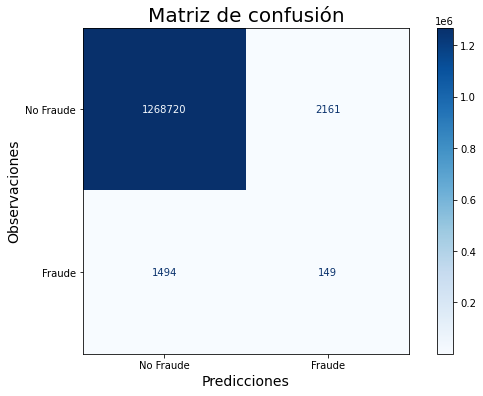

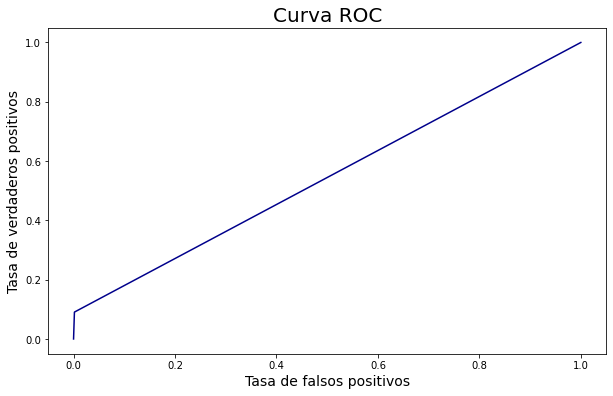

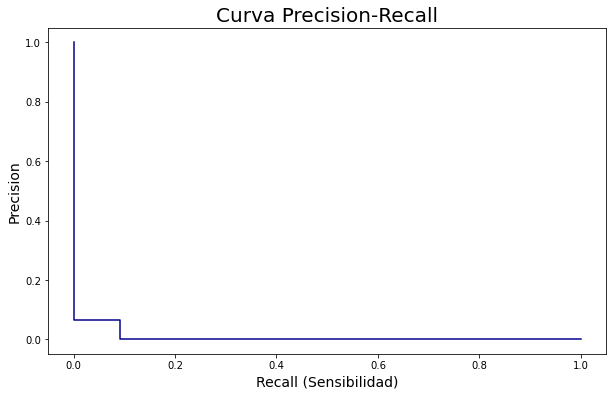

In [10]:
# Exportación a png.
from export import export_png_2
export_png_2(filename = 'kmeans_balanced', y_test = y_test, y_pred = y_pred)

In [37]:
# Reporte Precision, Recall, F1.
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names = ['Not Fraud', 'Fraud'], digits = 4))

              precision    recall  f1-score   support

   Not Fraud     0.9988    0.9983    0.9986   1270881
       Fraud     0.0645    0.0907    0.0754      1643

    accuracy                         0.9971   1272524
   macro avg     0.5317    0.5445    0.5370   1272524
weighted avg     0.9976    0.9971    0.9974   1272524



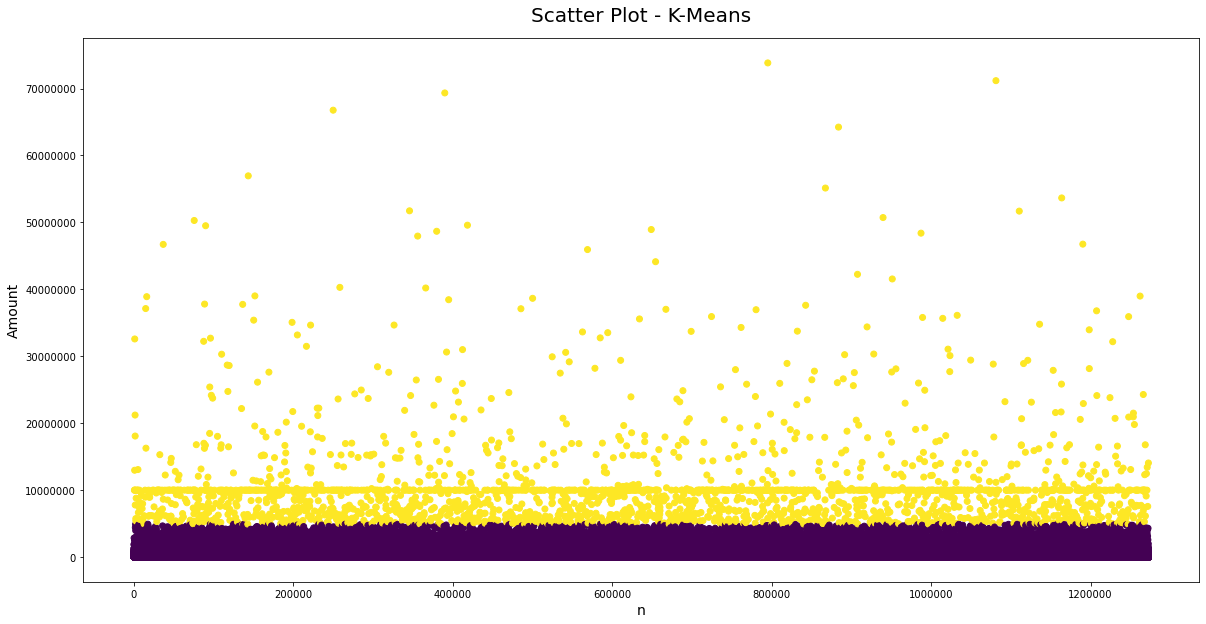

In [38]:
# Scatter plot con predicciones realizadas por K-Means.
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

df_disp = pd.DataFrame({'amount' : df_validation.amount, 'prediction' : y_pred})
df_disp = df_disp.reset_index()
df_disp = df_disp

fig, ax = plt.subplots(figsize = (20, 10))
fig = plt.scatter(x = df_disp.index, y = df_disp.amount, c = df_disp.prediction)
fig = plt.title(label = 'Scatter Plot - K-Means', fontdict = {'fontsize' : 20}, y = 1.02)
ax.set_xlabel('n', fontdict = {'fontsize' : 14})
ax.set_ylabel('Amount', fontdict = {'fontsize' : 14})
ax.xaxis.set_major_formatter(FormatStrFormatter('%i'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%i'))
plt.show()

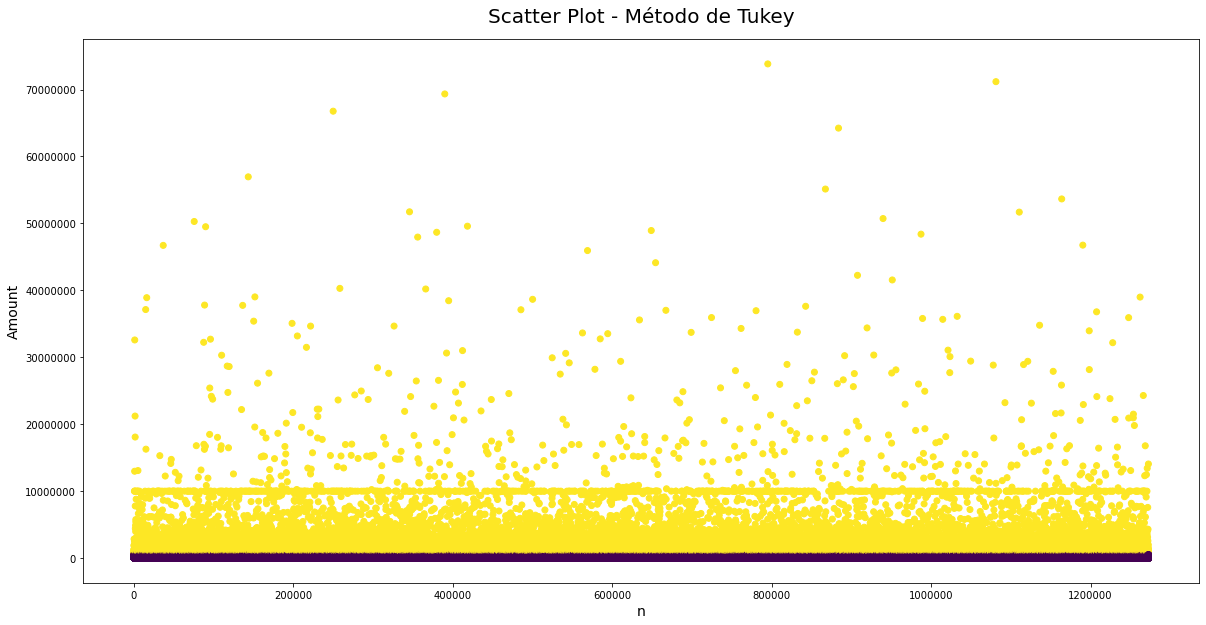

In [53]:
# Scatter plot con predicciones realizadas por el Método de Tukey.
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

df_disp = pd.DataFrame({'amount' : df_validation.amount, 'prediction' : y_pred})
df_disp = df_disp.reset_index()
df_disp = df_disp

fig, ax = plt.subplots(figsize = (20, 10))
fig = plt.scatter(x = df_disp.index, y = df_disp.amount, c = df_disp.prediction)
fig = plt.title(label = 'Scatter Plot - Método de Tukey', fontdict = {'fontsize' : 20}, y = 1.02)
ax.set_xlabel('n', fontdict = {'fontsize' : 14})
ax.set_ylabel('Amount', fontdict = {'fontsize' : 14})
ax.xaxis.set_major_formatter(FormatStrFormatter('%i'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%i'))
plt.show()